# Training NN-model for tabular data
In this notebook we train an NN-model using the similar approach as in the reference paper, i.e., we consider only tabular satellite data and not actual images.

In [1]:
import tensorflow.keras as K
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We exclide olc_id = 5G55HPG4+MM7 since no Sentinel-2 data available. For how the file Target_and_input.csv (input from OpenLandMap) was created take a look at Soil_Data_Preparation_v0.2.R. Warnning message is not relevant for us since later we will drop the column casing this warning

In [2]:
target_and_input_OpenLandMap = pd.read_csv("Target_and_input.csv")
target_and_input_OpenLandMap = target_and_input_OpenLandMap[target_and_input_OpenLandMap.olc_id != "5G55HPG4+MM7"]
target_and_input_OpenLandMap.shape

C:\Users\sprin\anaconda3\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(69068, 106)

Now, also get data from Sentinel-2. For how the file pixels_df.csv was created take a look at Download_Sentinel_2_Pixels.ipynb.

In [3]:
input_Sentinel_2 = pd.read_csv("pixels_df.csv")
input_Sentinel_2.shape

(15478, 14)

Merge OpenLandMap and Sentinel-2 data

In [4]:
all_data = target_and_input_OpenLandMap.merge(input_Sentinel_2, on='olc_id', how='left')
all_data.shape

(69068, 119)

Since we want to predict organic carbon (oc), we keep only those table rows where oc is not NA

In [5]:
all_data.dropna(subset=['oc'], inplace=True)

Now, drop some columns that we do not need. For definition of these columns, take a look at Soil_Data_Preparation_v0.2.R.
To summarize: we keep only:
 - Target variable (oc)
 - Measurements depth
 - Geo-coordinates (longitude and latitude)
 - Data from OpenLandMap
 - Data from Sentinel-2

In [6]:
all_data.drop(['olc_id','confidence_degree','uuid','site_obsdate','source_db','layer_sequence.f','hzn_top', 'hzn_bot', 'n_tot', 'ph_h2o'], axis=1, inplace=True)

In [7]:
all_data.columns

Index(['longitude_decimal_degrees', 'latitude_decimal_degrees', 'hzn_depth',
       'oc', 'clm_precipitation_sm2rain.apr_m_1km_s0..0cm_2007..2018_v0.2.tif',
       'clm_precipitation_sm2rain.aug_m_1km_s0..0cm_2007..2018_v0.2.tif',
       'clm_precipitation_sm2rain.dec_m_1km_s0..0cm_2007..2018_v0.2.tif',
       'clm_precipitation_sm2rain.feb_m_1km_s0..0cm_2007..2018_v0.2.tif',
       'clm_precipitation_sm2rain.jan_m_1km_s0..0cm_2007..2018_v0.2.tif',
       'clm_precipitation_sm2rain.jul_m_1km_s0..0cm_2007..2018_v0.2.tif',
       ...
       'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12'],
      dtype='object', length=109)

Let's take a look at distribution of oc

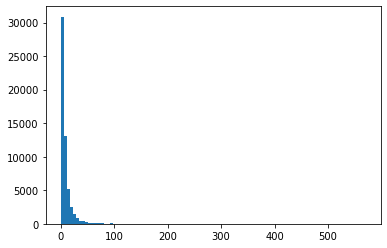

In [8]:
_ = plt.hist(all_data['oc'], bins=100)
plt.show()

We drop all measurements above (or equal to) 120 for following reasons:

- It is only 193 measurement points (0.344 %), so it might be anomalies (#sum(all_data['oc']>=120)/all_data['oc'].shape[0]*100)
- typical soils are between 5 and 30. Soils with organic carbon > 120-180 are considered in general as organic soils, also called histol. Histosol seems to be very rare in Africa and is not suitable for cultivation, see: https://en.wikipedia.org/wiki/Histosol and https://www.researchgate.net/figure/2-Distribution-of-Histosols-in-Africa-at-continental-scale-after-Koohafkan-et-al_fig3_323624025
- In the reference paper (https://www.nature.com/articles/s41598-021-85639-y#Tab1) in Fig.4, the authors seem to not bother about values above 200.
- iSDAsoil (https://www.isda-africa.com/isdasoil/) is based on the reference paper and seems to not trusts its own predictions above 40. 

Altoghether: exclusion of vcalues above 120 seems to be a reasonable compromise and do not affect the future "every-day"-
application of our system since (probably) nobody will want to plant anything in histosol.

In [9]:
all_data = all_data[all_data['oc'] < 120]  

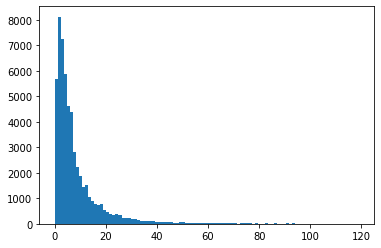

In [10]:
_ = plt.hist(all_data['oc'], bins=100)
plt.show()

Split the data into train, validate, and test data sets with controlled seed.

But before, here some remaks on training strategy:
We randomely split the data set into Training, Development, and Test data sets.
1. Training data (60% of all data): are used to train the model
2. Validation data (20% of all data): are evaluated during the training but are not used for training. Observing evolution of optimization metric on this data set allows prevent overfitting.
3. Test data (20% of all data): Data never seen by an algorithm. This data is used to evaluate the quality of the algorithm.

After a model is trained and relevant metrics set are calculated on test data, we also need to know how much we can trust these results. The reason for potential mistrust is that even though the splitting of data into training/validation/test data sets is made randomly, a particular choice of training data might have impact on the accuracy metrics. It means that applied on completely new data, the model would produce predictions of different accuracy. To take this effect into account, we will repeat the random splitting 10 times (with different seeds). Then the model is trained from scratch without changing any of hyperparameters. The resulting metrics are then combined with the original metrics. So, we have 11 measurements for each relevant metric that have some particular distribution. This distribution is much better indicator of model quality as only one measurements of a metric. This procedure is basically equivalent to nested 2-fold cross validation.

In [11]:
train, validate, test = \
              np.split(all_data.sample(frac=1, random_state=42), 
                       [int(.6*len(all_data)), int(.8*len(all_data))])

In [12]:
all_data.shape, train.shape, validate.shape, test.shape

((55885, 109), (33531, 109), (11177, 109), (11177, 109))

Some of the innputs from OpenLandMap and Sentinel-2 images have NAs. For the very first MVp, we simply set NAs to zero. It might not be an ideal choise, especially for data like temperature. We need to invest more time in better dealing with NAs in the future. Also, maybe it is better/easier to just drop all NAs (we will lose over 2k data points, but we will still have 53.462) For now, only some statistics on NAs (variable is mentioned only if it has NAs: 

- dtm_landform_usgs.ecotapestry_c_250m_s0..0cm_2014_v1.0.tif: 177
- dtm_lithology_usgs.ecotapestry_c_250m_s0..0cm_2014_v1.0.tif: 177
- clm_snow.prob_esacci.apr_p_1km_s0..0cm_2000..2016_v1.0.tif: 30
- clm_snow.prob_esacci.aug_p_1km_s0..0cm_2000..2016_v1.0.tif: 125
- clm_snow.prob_esacci.jul_p_1km_s0..0cm_2000..2016_v1.0.tif: 19
- clm_snow.prob_esacci.jun_p_1km_s0..0cm_2000..2016_v1.0.tif: 31
- clm_snow.prob_esacci.mar_p_1km_s0..0cm_2000..2016_v1.0.tif: 10
- clm_snow.prob_esacci.may_p_1km_s0..0cm_2000..2016_v1.0.tif: 24
- clm_snow.prob_esacci.oct_p_1km_s0..0cm_2000..2016_v1.0.tif: 19
- clm_snow.prob_esacci.sep_p_1km_s0..0cm_2000..2016_v1.0.tif: 62
- dtm_aspect-cosine_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_aspect-sine_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_convergence_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_cti_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_dev-magnitude_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_dev-scale_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_easthness_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_geom_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_northness_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_pcurv_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_rough-magnitude_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_rough-scale_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_roughness_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_tcurv_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- dtm_vrm_merit.dem_m_250m_s0..0cm_2018_v1.0.tif: 5
- clm_lst_mod11a2.apr.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.apr.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.apr.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 112
- clm_lst_mod11a2.aug.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 347
- clm_lst_mod11a2.aug.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 939
- clm_lst_mod11a2.aug.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 1159
- clm_lst_mod11a2.dec.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.dec.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.dec.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 141
- clm_lst_mod11a2.feb.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.feb.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.feb.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.jan.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.jan.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.jan.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.jul.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 130
- clm_lst_mod11a2.jul.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 202
- clm_lst_mod11a2.jul.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 432
- clm_lst_mod11a2.jun.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.jun.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 106
- clm_lst_mod11a2.jun.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 153
- clm_lst_mod11a2.mar.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.mar.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.mar.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.may.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.may.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 101
- clm_lst_mod11a2.may.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 105
- clm_lst_mod11a2.nov.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 106
- clm_lst_mod11a2.nov.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 106
- clm_lst_mod11a2.nov.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 213
- clm_lst_mod11a2.oct.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 181
- clm_lst_mod11a2.oct.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 291
- clm_lst_mod11a2.oct.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 404
- clm_lst_mod11a2.sep.day_m_1km_s0..0cm_2000..2017_v1.0.tif: 122
- clm_lst_mod11a2.sep.day_sd_1km_s0..0cm_2000..2017_v1.0.tif: 230
- clm_lst_mod11a2.sep.daynight_m_1km_s0..0cm_2000..2017_v1.0.tif: 630
- veg_fapar_proba.v.aug_d_250m_s0..0cm_2014..2017_v1.0.tif: 28
- veg_fapar_proba.v.jul_d_250m_s0..0cm_2014..2017_v1.0.tif: 16
- veg_fapar_proba.v.sep_d_250m_s0..0cm_2014..2017_v1.0.tif: 21
- B01: 6
- B02: 6
- B03: 6
- B04: 6
- B05: 6
- B06: 6
- B07: 6
- B08: 6
- B8A: 6
- B09: 6
- B10: 6
- B11: 6
- B12: 6

In [110]:
train_targets = train["oc"]
validate_targets = validate["oc"]
test_targets = test["oc"]

In [111]:
train_inputs = train.drop(['oc'], axis=1)
validate_inputs = validate.drop(['oc'], axis=1)
test_inputs = test.drop(['oc'], axis=1)

train_inputs.fillna(0, inplace = True)
validate_inputs.fillna(0, inplace = True)
test_inputs.fillna(0, inplace = True)

We use min-max nbormalization since it is common for images (even though, currently we use only tabular input). It means all input data is normalized to 0-1

In [112]:
min_values = train_inputs.min(axis=0)
max_values = train_inputs.max(axis=0)

In [113]:
min_values.to_csv("min_values.csv",index=False)
max_values.to_csv("max_values.csv",index=False)

In [114]:
train_inputs=(train_inputs-min_values)/(max_values-min_values)
validate_inputs=(validate_inputs-min_values)/(max_values-min_values)
test_inputs=(test_inputs-min_values)/(max_values-min_values)

Important assumption: to derive actions for farmers based on soil quality factors, there is a need for precise predictions of organic carbon at lower scales (where it might decide about life and death). At higher scales, however, precision is not so important (there is for sure enough oc in the soil). So, we should bias the model towards better presision at lower scales. Therefore, instead of predicting oc, we should predict logarithm of it. To also be able to predict oc = 0, we should use transformation ln(oc+1). In the reference paper, the authors do the same.

In [115]:
train_targets = np.log(train_targets+1)
validate_targets = np.log(validate_targets+1)
test_targets = np.log(test_targets+1)

In [118]:
train_inputs = train_inputs.to_numpy()
validate_inputs = validate_inputs.to_numpy()
test_inputs = test_inputs.to_numpy()

train_targets = train_targets.to_numpy()
validate_targets = validate_targets.to_numpy()
test_targets = test_targets.to_numpy()

Below, the actual model is defined. It is a quite simple Deep NN with batch normalization. The latter is good accelerating learning process and also has some moderate regulirization effect. In the first experiments, I did not observe the need for more regularization.

In [22]:
model = K.models.Sequential()
model.add(K.Input(shape=(108,)))
model.add(K.layers.Dense(512, activation='relu'))
#model.add(K.layers.Dropout(0.05))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
#model.add(K.layers.Dropout(0.05))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
#model.add(K.layers.Dropout(0.05))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
#model.add(K.layers.Dropout(0.05))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(1, activation='linear'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               55808     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

We use Early Stopping on validation data set with patience=30. I.e., if the optimization function (in this case mse: mean-square-error) on validation data set does not improve for 30 epochs, the training process is stopped and the model coefficients that produced the best mse for validation data set are restored.
Max number of epoches is 30 and batch sized used is 32.

In [24]:
batch_siz = 32
num_epochs = 300
callback = K.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights = True)

In [25]:
model.compile(loss='mse',
              optimizer=K.optimizers.Adam(learning_rate=0.0001)
             )

In [26]:
history = model.fit(train_inputs,train_targets,
                    validation_data=(validate_inputs,validate_targets),
                    epochs=num_epochs,
                    callbacks=[callback])

Epoch 1/300
1048/1048 [==============================] - 6s 4ms/step - loss: 2.4840 - val_loss: 0.9478
Epoch 2/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.5832 - val_loss: 0.3660
Epoch 3/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3815 - val_loss: 0.3706
Epoch 4/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3502 - val_loss: 0.3365
Epoch 5/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3318 - val_loss: 0.3029
Epoch 6/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3204 - val_loss: 0.3167
Epoch 7/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3074 - val_loss: 0.3008
Epoch 8/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2979 - val_loss: 0.2939
Epoch 9/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2934 - val_loss: 0.2815
Epoch 10/300
1048/1048 [==============================] - 4s 4ms/step - l

Epoch 80/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1583 - val_loss: 0.2098
Epoch 81/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1586 - val_loss: 0.2252
Epoch 82/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1577 - val_loss: 0.2149
Epoch 83/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1589 - val_loss: 0.2164
Epoch 84/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1576 - val_loss: 0.2241
Epoch 85/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1546 - val_loss: 0.2105
Epoch 86/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1565 - val_loss: 0.2110
Epoch 87/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1527 - val_loss: 0.2039
Epoch 88/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1537 - val_loss: 0.2117
Epoch 89/300
1048/1048 [==============================] - 4s 4ms

In [28]:
#model.save('model_as_in_paper_with_sentinel_regression.h5')

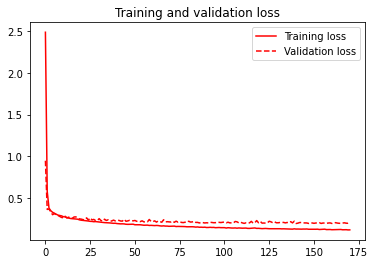

In [29]:
# import matplotlib to plot training evolution.
import matplotlib.pyplot as plt

#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

#plt.plot(epochs, acc, 'b', label='Training acc')
#plt.plot(epochs, val_acc, 'b--', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

#plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Finally, we can produce predictions. Thereby following should be considered:
 - every prediction < 0 must be set to zero. Otherwise oc also becomes negative and it does not make sence
 - we evaluate on all data sets for completeness: training, validation, and test
 - The major metric of interest is root mean squared error (rmse) since it is also used as metric in the reference paper
 - In addition, one could also redefine the problem as classification problem (instead of regression). As a kind of natural classes one can use rounded ln(oc+1). I.e.,
    1.	Class 0 corresponds to oc between 0 and 0.65
    2.	Class 1 corresponds to oc between 0.65 and 3.5
    3.	Class 2 corresponds to oc between 3.5 and 11.2
    4.	Class 3 corresponds to oc between 11.2 and 32.1
    5.	Class 4 corresponds to oc between 32.1 and 89.0
    6.	Class 5 corresponds to oc between 89.0 and 120
    
   The metric here is be the number of data points with correctly predicted classes divided by the number of data points (accuracy). Note that I tried to build classification models, but in my experiments, they produced not so good results as regression models (accuracy was used to compare the models). The reason might be that classification models do not recognize natural order of classes. Nonetheless, I still report also the accuracy as metric to provide a better feeling on quality of the model.


First, training data

In [30]:
train_predictions = pd.DataFrame(model.predict(train_inputs))
train_df = pd.DataFrame(train_targets)

In [31]:
train_predictions.clip(lower=0, inplace=True)

In [32]:
np.sqrt(np.square(train_predictions - train_df).sum(axis=0)/train_df.shape[0])

0    0.290209
dtype: float64

In [33]:
(np.round(train_predictions) == np.round(train_df)).sum(axis=0)/train_df.shape[0]

0    0.789836
dtype: float64

Plot distribution of actual and predicted target values

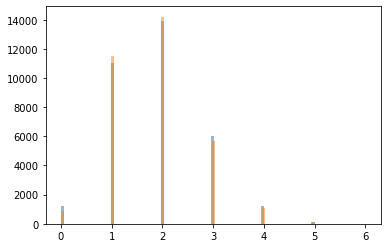

In [34]:
_ = plt.hist(np.round(train_df), bins='auto', alpha=0.5)
_ = plt.hist(np.round(train_predictions), bins='auto', alpha=0.5)
plt.show()

Now, validation data

In [35]:
validate_predictions = pd.DataFrame(model.predict(validate_inputs))
validate_df = pd.DataFrame(validate_targets)

In [36]:
validate_predictions.clip(lower=0, inplace=True)

In [37]:
np.sqrt(np.square(validate_predictions - validate_df).sum(axis=0)/validate_df.shape[0])

0    0.444209
dtype: float64

In [38]:
(np.round(validate_predictions) == np.round(validate_df)).sum(axis=0)/validate_df.shape[0]

0    0.692494
dtype: float64

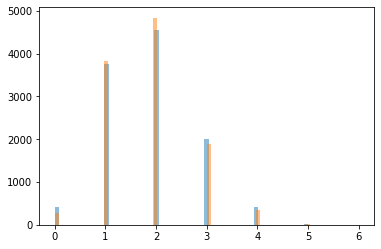

In [39]:
_ = plt.hist(np.round(validate_df), bins='auto', alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(np.round(validate_predictions), bins='auto', alpha=0.5)
plt.show()

And finally testing data

In [40]:
test_predictions =pd.DataFrame(model.predict(test_inputs))
test_df = pd.DataFrame(test_targets)

In [41]:
test_predictions.clip(lower=0, inplace=True)

In [42]:
np.sqrt(np.square(test_predictions - test_df).sum(axis=0)/test_df.shape[0])

0    0.439565
dtype: float64

In [43]:
(np.round(test_predictions) == np.round(test_df)).sum(axis=0)/test_df.shape[0]

0    0.699472
dtype: float64

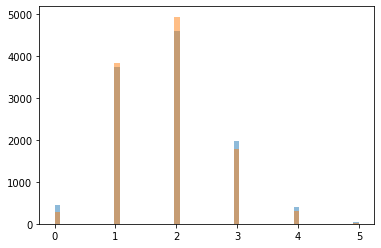

In [44]:
_ = plt.hist(np.round(test_df), bins='auto', alpha=0.5)  # arguments are passed to np.histogram
_ = plt.hist(np.round(test_predictions), bins='auto', alpha=0.5)
plt.show()

## Summary for one model
 - RMSE
   - Train: 0.290209
   - Valid: 0.444209
   - Test: 0.439565

 - Accuracy (rounded in classes)
   - Train: 0.789836
   - Valid: 0.692494
   - Test: 0.699472

## Error Estimation
Now, as already mentioned above we repeat the same process 10 times to estimate the error of our metrices. Thereby, different seeds are used to split the data

In [46]:
seeds = [24,3,123,7,666,5,10,1993,13,12]

In [47]:
rmse_train = []
rmse_valid = []
rmse_test = []

acc_train = []
acc_valid = []
acc_test = []



for i in seeds:
    target_and_input_OpenLandMap = pd.read_csv("Target_and_input.csv")
    target_and_input_OpenLandMap = target_and_input_OpenLandMap[target_and_input_OpenLandMap.olc_id != "5G55HPG4+MM7"]
    input_Sentinel_2 = pd.read_csv("pixels_df.csv")
    all_data = target_and_input_OpenLandMap.merge(input_Sentinel_2, on='olc_id', how='left')
    all_data.dropna(subset=['oc'], inplace=True)
    all_data.drop(['olc_id','confidence_degree','uuid','site_obsdate','source_db','layer_sequence.f','hzn_top', 'hzn_bot', 'n_tot', 'ph_h2o'], axis=1, inplace=True)
    all_data = all_data[all_data['oc'] < 120]  
    train, validate, test = \
              np.split(all_data.sample(frac=1, random_state=i), 
                       [int(.6*len(all_data)), int(.8*len(all_data))])
    
    train_targets = train["oc"]
    validate_targets = validate["oc"]
    test_targets = test["oc"]
    
    train_inputs = train.drop(['oc'], axis=1)
    validate_inputs = validate.drop(['oc'], axis=1)
    test_inputs = test.drop(['oc'], axis=1)
    
    train_inputs.fillna(0, inplace = True)
    validate_inputs.fillna(0, inplace = True)
    test_inputs.fillna(0, inplace = True)
    
    min_values = train_inputs.min(axis=0)
    max_values = train_inputs.max(axis=0)
    
    train_inputs=(train_inputs-min_values)/(max_values-min_values)
    validate_inputs=(validate_inputs-min_values)/(max_values-min_values)
    test_inputs=(test_inputs-min_values)/(max_values-min_values)
    
    train_targets = np.log(train_targets+1)
    validate_targets = np.log(validate_targets+1)
    test_targets = np.log(test_targets+1)
    
    train_inputs = train_inputs.to_numpy()
    validate_inputs = validate_inputs.to_numpy()
    test_inputs = test_inputs.to_numpy()
    
    train_targets = train_targets.to_numpy()
    validate_targets = validate_targets.to_numpy()
    test_targets = test_targets.to_numpy()
    
    model = K.models.Sequential()
    model.add(K.Input(shape=(108,)))
    model.add(K.layers.Dense(512, activation='relu'))
    #model.add(K.layers.Dropout(0.05))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    #model.add(K.layers.Dropout(0.05))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    #model.add(K.layers.Dropout(0.05))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    #model.add(K.layers.Dropout(0.05))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(1, activation='linear'))
    
    batch_siz = 32
    num_epochs = 300
    callback = K.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights = True)
    
    model.compile(loss='mse',
              optimizer=K.optimizers.Adam(learning_rate=0.0001)
             )
    
    history = model.fit(train_inputs,train_targets,
                    validation_data=(validate_inputs,validate_targets),
                    epochs=num_epochs,
                    callbacks=[callback])
    
    
    train_predictions = pd.DataFrame(model.predict(train_inputs))
    train_df = pd.DataFrame(train_targets)
    train_predictions.clip(lower=0, inplace=True)
    
    rmse_train.append(np.sqrt(np.square(train_predictions - train_df).sum(axis=0)/train_df.shape[0])[0])
    acc_train.append(((np.round(train_predictions) == np.round(train_df)).sum(axis=0)/train_df.shape[0])[0])
    
    validate_predictions = pd.DataFrame(model.predict(validate_inputs))
    validate_df = pd.DataFrame(validate_targets)
    validate_predictions.clip(lower=0, inplace=True)
    
    rmse_valid.append(np.sqrt(np.square(validate_predictions - validate_df).sum(axis=0)/validate_df.shape[0])[0])
    acc_valid.append(((np.round(validate_predictions) == np.round(validate_df)).sum(axis=0)/validate_df.shape[0])[0])
    
    test_predictions =pd.DataFrame(model.predict(test_inputs))
    test_df = pd.DataFrame(test_targets)
    test_predictions.clip(lower=0, inplace=True)
    
    rmse_test.append(np.sqrt(np.square(test_predictions - test_df).sum(axis=0)/test_df.shape[0])[0])
    acc_test.append(((np.round(test_predictions) == np.round(test_df)).sum(axis=0)/test_df.shape[0])[0])
    
    model.save('Models_eval_as_in_paper/model_without_images_regression_seed_'+str(i)+'.h5')
    
    print(i)

Epoch 1/300
1048/1048 [==============================] - 5s 5ms/step - loss: 2.4583 - val_loss: 1.4420
Epoch 2/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.5832 - val_loss: 0.3650
Epoch 3/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3783 - val_loss: 0.3494
Epoch 4/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3436 - val_loss: 0.3127
Epoch 5/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3274 - val_loss: 0.3047
Epoch 6/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.3108 - val_loss: 0.2843
Epoch 7/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.3052 - val_loss: 0.2861
Epoch 8/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2947 - val_loss: 0.2947
Epoch 9/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2897 - val_loss: 0.2797
Epoch 10/300
1048/1048 [==============================] - 4s 4ms/step - l

Epoch 80/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1600 - val_loss: 0.2146
Epoch 81/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1583 - val_loss: 0.2043
Epoch 82/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1606 - val_loss: 0.2042
Epoch 83/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1581 - val_loss: 0.2149
Epoch 84/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1575 - val_loss: 0.2071
Epoch 85/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1566 - val_loss: 0.2085
Epoch 86/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1558 - val_loss: 0.2148
Epoch 87/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1553 - val_loss: 0.2051
Epoch 88/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1559 - val_loss: 0.2075
Epoch 89/300
1048/1048 [==============================] - 4s 4ms

Epoch 55/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1823 - val_loss: 0.2228
Epoch 56/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1792 - val_loss: 0.2252
Epoch 57/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1788 - val_loss: 0.2287
Epoch 58/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1788 - val_loss: 0.2201
Epoch 59/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1778 - val_loss: 0.2217
Epoch 60/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1761 - val_loss: 0.2224
Epoch 61/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1778 - val_loss: 0.2208
Epoch 62/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1739 - val_loss: 0.2162
Epoch 63/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1739 - val_loss: 0.2186
Epoch 64/300
1048/1048 [==============================] - 4s 4ms

1048/1048 [==============================] - 4s 4ms/step - loss: 0.1868 - val_loss: 0.2188
Epoch 51/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1856 - val_loss: 0.2191
Epoch 52/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1864 - val_loss: 0.2245
Epoch 53/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1817 - val_loss: 0.2750
Epoch 54/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1828 - val_loss: 0.2223
Epoch 55/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1830 - val_loss: 0.2199
Epoch 56/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1810 - val_loss: 0.2206
Epoch 57/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1804 - val_loss: 0.2202
Epoch 58/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1781 - val_loss: 0.2164
Epoch 59/300
1048/1048 [==============================] - 4s 4ms/step - loss:

1048/1048 [==============================] - 4s 4ms/step - loss: 0.2792 - val_loss: 0.2873
Epoch 12/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2751 - val_loss: 0.2685
Epoch 13/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2700 - val_loss: 0.2740
Epoch 14/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2641 - val_loss: 0.2635
Epoch 15/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2569 - val_loss: 0.2479
Epoch 16/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2537 - val_loss: 0.2605
Epoch 17/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2523 - val_loss: 0.2503
Epoch 18/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2493 - val_loss: 0.2669
Epoch 19/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.2437 - val_loss: 0.2442
Epoch 20/300
1048/1048 [==============================] - 4s 4ms/step - loss:

Epoch 90/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1543 - val_loss: 0.2247
Epoch 91/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1548 - val_loss: 0.2060
Epoch 92/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1543 - val_loss: 0.2061
Epoch 93/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1538 - val_loss: 0.2060
Epoch 94/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1539 - val_loss: 0.1992
Epoch 95/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1516 - val_loss: 0.2162
Epoch 96/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1535 - val_loss: 0.2082
Epoch 97/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1504 - val_loss: 0.2035
Epoch 98/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1514 - val_loss: 0.2136
Epoch 99/300
1048/1048 [==============================] - 4s 4ms

Epoch 98/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1506 - val_loss: 0.2207
Epoch 99/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1505 - val_loss: 0.2073
Epoch 100/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1475 - val_loss: 0.2113
Epoch 101/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1515 - val_loss: 0.2049
Epoch 102/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1483 - val_loss: 0.2156
Epoch 103/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1476 - val_loss: 0.2114
Epoch 104/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1432 - val_loss: 0.2108
Epoch 105/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1468 - val_loss: 0.2315
Epoch 106/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1467 - val_loss: 0.2210
Epoch 107/300
1048/1048 [==============================] 

Epoch 111/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1417 - val_loss: 0.2103
Epoch 112/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1408 - val_loss: 0.2141
Epoch 113/300
1048/1048 [==============================] - 5s 5ms/step - loss: 0.1414 - val_loss: 0.2007
Epoch 114/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1392 - val_loss: 0.2121
Epoch 115/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1432 - val_loss: 0.2087
Epoch 116/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1407 - val_loss: 0.2071
Epoch 117/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1417 - val_loss: 0.2061
Epoch 118/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1423 - val_loss: 0.2087
Epoch 119/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1381 - val_loss: 0.2037
Epoch 120/300
1048/1048 [==============================

Epoch 109/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1420 - val_loss: 0.2127
Epoch 110/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1447 - val_loss: 0.2136
Epoch 111/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1417 - val_loss: 0.2252
Epoch 112/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1431 - val_loss: 0.2114
Epoch 113/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1439 - val_loss: 0.2170
Epoch 114/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1437 - val_loss: 0.2178
Epoch 115/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1408 - val_loss: 0.2064
Epoch 116/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1407 - val_loss: 0.2236
Epoch 117/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1394 - val_loss: 0.2138
Epoch 118/300
1048/1048 [==============================

Epoch 92/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1557 - val_loss: 0.2052
Epoch 93/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1536 - val_loss: 0.2049
Epoch 94/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1555 - val_loss: 0.2103
Epoch 95/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1520 - val_loss: 0.2073
Epoch 96/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1529 - val_loss: 0.2190
Epoch 97/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1502 - val_loss: 0.2091
Epoch 98/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1522 - val_loss: 0.2103
Epoch 99/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1501 - val_loss: 0.2071
Epoch 100/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1495 - val_loss: 0.2067
Epoch 101/300
1048/1048 [==============================] - 5s 4

Epoch 87/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1593 - val_loss: 0.2112
Epoch 88/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1558 - val_loss: 0.2608
Epoch 89/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1549 - val_loss: 0.2502
Epoch 90/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1561 - val_loss: 0.2117
Epoch 91/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1552 - val_loss: 0.2117
Epoch 92/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1542 - val_loss: 0.2169
Epoch 93/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1525 - val_loss: 0.2086
Epoch 94/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1521 - val_loss: 0.2134
Epoch 95/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1523 - val_loss: 0.2075
Epoch 96/300
1048/1048 [==============================] - 4s 4ms

Epoch 63/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1716 - val_loss: 0.2288
Epoch 64/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1714 - val_loss: 0.2254
Epoch 65/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1740 - val_loss: 0.2229
Epoch 66/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1708 - val_loss: 0.2174
Epoch 67/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1710 - val_loss: 0.2139
Epoch 68/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1692 - val_loss: 0.2229
Epoch 69/300
1048/1048 [==============================] - 5s 5ms/step - loss: 0.1695 - val_loss: 0.2481
Epoch 70/300
1048/1048 [==============================] - 4s 4ms/step - loss: 0.1672 - val_loss: 0.2163
Epoch 71/300
1048/1048 [==============================] - 5s 4ms/step - loss: 0.1662 - val_loss: 0.2140
Epoch 72/300
1048/1048 [==============================] - 4s 4ms

In [48]:
rmse_train

[0.33029161217455777,
 0.2975469984768751,
 0.28819609199989105,
 0.3029086318817659,
 0.3043515483418198,
 0.29794488513707507,
 0.29190854563085217,
 0.29571383467274004,
 0.29392293460051494,
 0.3074806478213045]

In [49]:
acc_train

[0.7620410962989472,
 0.7870627180817751,
 0.7895976857236587,
 0.7783841818019146,
 0.7772807252989771,
 0.7842295189526111,
 0.7889713996003698,
 0.7865557245533984,
 0.7874802421639677,
 0.7744773493185411]

In [50]:
rmse_valid

[0.4476343573829571,
 0.4445612574383707,
 0.44677419359572274,
 0.44380444444039724,
 0.446394896295985,
 0.4449875464062585,
 0.4472438343062849,
 0.44170163603920726,
 0.44388684483460283,
 0.4460656326534337]

In [51]:
acc_valid

[0.6830097521696341,
 0.6914198801109421,
 0.686409591124631,
 0.6903462467567326,
 0.6870358772479198,
 0.685693835555158,
 0.6958933524201485,
 0.6930303301422565,
 0.6902567773105485,
 0.6860517133398945]

In [52]:
rmse_test

[0.45975335389501587,
 0.44332743102471567,
 0.4413642957996906,
 0.4433037574544462,
 0.44356387337047104,
 0.4368064361093876,
 0.440301451142748,
 0.4428163527140393,
 0.44220878540134734,
 0.4575938247322753]

In [53]:
acc_test

[0.6840833855238436,
 0.6860517133398945,
 0.6866779994631833,
 0.6838149771852913,
 0.695535474635412,
 0.6919566967880468,
 0.694819719065939,
 0.6924935134651516,
 0.6905251856491008,
 0.680862485461215]

In [54]:
results_errors = pd.DataFrame({'seeds':seeds,
                               'rmse_train': rmse_train, 'acc_train': acc_train,
                              'rmse_valid': rmse_valid, 'acc_valid': acc_valid,
                              'rmse_test': rmse_test, 'acc_test': acc_test})

In [55]:
results_errors

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24,0.330292,0.762041,0.447634,0.683010,0.459753,0.684083
1,3,0.297547,0.787063,0.444561,0.691420,0.443327,0.686052
2,123,0.288196,0.789598,0.446774,0.686410,0.441364,0.686678
3,7,0.302909,0.778384,0.443804,0.690346,0.443304,0.683815
4,666,0.304352,0.777281,0.446395,0.687036,0.443564,0.695535
5,5,0.297945,0.784230,0.444988,0.685694,0.436806,0.691957
6,10,0.291909,0.788971,0.447244,0.695893,0.440301,0.694820
7,1993,0.295714,0.786556,0.441702,0.693030,0.442816,0.692494
8,13,0.293923,0.787480,0.443887,0.690257,0.442209,0.690525
9,12,0.307481,0.774477,0.446066,0.686052,0.457594,0.680862


In [56]:
results_errors.min(axis=0)

seeds         3.000000
rmse_train    0.288196
acc_train     0.762041
rmse_valid    0.441702
acc_valid     0.683010
rmse_test     0.436806
acc_test      0.680862
dtype: float64

In [57]:
results_errors.max(axis=0)

seeds         1993.000000
rmse_train       0.330292
acc_train        0.789598
rmse_valid       0.447634
acc_valid        0.695893
rmse_test        0.459753
acc_test         0.695535
dtype: float64

save all results

In [58]:
#results_errors.to_csv('as_paper_results_errors_reg.csv', index=False)  

Now, also add results from the oiginal model

In [59]:
as_paper_results_errors_reg = pd.read_csv("as_paper_results_errors_reg.csv")

In [60]:
as_paper_results_errors_reg

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24,0.330292,0.762041,0.447634,0.683010,0.459753,0.684083
1,3,0.297547,0.787063,0.444561,0.691420,0.443327,0.686052
2,123,0.288196,0.789598,0.446774,0.686410,0.441364,0.686678
3,7,0.302909,0.778384,0.443804,0.690346,0.443304,0.683815
4,666,0.304352,0.777281,0.446395,0.687036,0.443564,0.695535
5,5,0.297945,0.784230,0.444988,0.685694,0.436806,0.691957
6,10,0.291909,0.788971,0.447244,0.695893,0.440301,0.694820
7,1993,0.295714,0.786556,0.441702,0.693030,0.442816,0.692494
8,13,0.293923,0.787480,0.443887,0.690257,0.442209,0.690525
9,12,0.307481,0.774477,0.446066,0.686052,0.457594,0.680862


In [61]:
as_paper_results_errors_reg = as_paper_results_errors_reg.append({'seeds': 42, 'rmse_train': 0.290209, 'acc_train': 0.789836,
                                   'rmse_valid': 0.444209, 'acc_valid': 0.692494,
                                   'rmse_test': 0.439565, 'acc_test': 0.699472}, ignore_index = True)

In [62]:
as_paper_results_errors_reg

,seeds,rmse_train,acc_train,rmse_valid,acc_valid,rmse_test,acc_test
0,24.0,0.330292,0.762041,0.447634,0.683010,0.459753,0.684083
1,3.0,0.297547,0.787063,0.444561,0.691420,0.443327,0.686052
2,123.0,0.288196,0.789598,0.446774,0.686410,0.441364,0.686678
3,7.0,0.302909,0.778384,0.443804,0.690346,0.443304,0.683815
4,666.0,0.304352,0.777281,0.446395,0.687036,0.443564,0.695535
5,5.0,0.297945,0.784230,0.444988,0.685694,0.436806,0.691957
6,10.0,0.291909,0.788971,0.447244,0.695893,0.440301,0.694820
7,1993.0,0.295714,0.786556,0.441702,0.693030,0.442816,0.692494
8,13.0,0.293923,0.787480,0.443887,0.690257,0.442209,0.690525
9,12.0,0.307481,0.774477,0.446066,0.686052,0.457594,0.680862


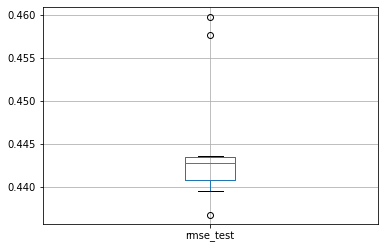

In [63]:
boxplot = as_paper_results_errors_reg.boxplot(column=["rmse_test"])

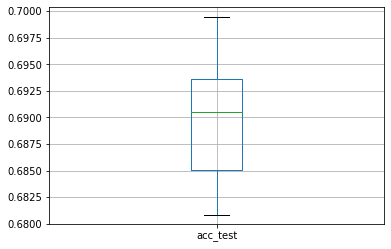

In [64]:
boxplot = as_paper_results_errors_reg.boxplot(column=["acc_test"])